# Imoprting Required Libraries

In [1]:
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Directions and Loading

In [2]:
dataset_root_dir = r'E:\University of Kerman\Term 7\Machine Learning\HomeWorks_Repo\ML-2024\Analyzing Titanic Survival Rates\Dataset\titanic'
train_dataset_dir = os.path.join(dataset_root_dir, 'train.csv')
test_dataset_dir = os.path.join(dataset_root_dir, 'test.csv')
target_dataset_dir = os.path.join(dataset_root_dir, 'gender_submission.csv')

In [3]:
train_df = pd.read_csv(train_dataset_dir, index_col='PassengerId')
test_df = pd.read_csv(test_dataset_dir, index_col='PassengerId')
target_df = pd.read_csv(target_dataset_dir, index_col='PassengerId')

# Load and expolore

## Concating the train and test data frame
In this section I will concat train and test data frame because we are not going to train any model and as a result, test set won't come in handy.

In [5]:
target_df.head()

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


There is **no** `Survived` column in test data, so in the outset, we have to inner join test dataset with gender_submission dataset on `PassengerId` column which is a foregin key to test dataset.

In [6]:
test_df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
test_df = test_df.join(target_df, on='PassengerId')

In [8]:
# The final data frame
df = pd.concat([train_df, test_df])

## A View of Data frame

In [9]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
df.tail()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1305,0,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1306,1,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1307,0,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1308,0,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
1309,0,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


### Dataset Shape

In [32]:
print('Number of Samples', len(df))
print()
print('columns are: ', df.columns)
print()
print('Dataset Shape is: ', df.shape)

Number of Samples 1309

columns are:  Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Dataset Shape is:  (1309, 11)


# Data Cleaning

## Handling null values

### Overview on missing values

In [33]:
# Calculating the null and not null values
null_counts = df.isnull().sum()
not_null_counts = df.count()

# automatically collecting column names that has null values, to show a pie chart for each of them
null_columns = []
for idx, isnull in null_counts.items():
    if isnull > 0:
        null_columns.append((idx, isnull, not_null_counts[idx]))

# making a data frame that will be used for drawing plots
vis_df = pd.DataFrame({'null count': null_counts, 'not null count': not_null_counts}, index=null_counts.index)

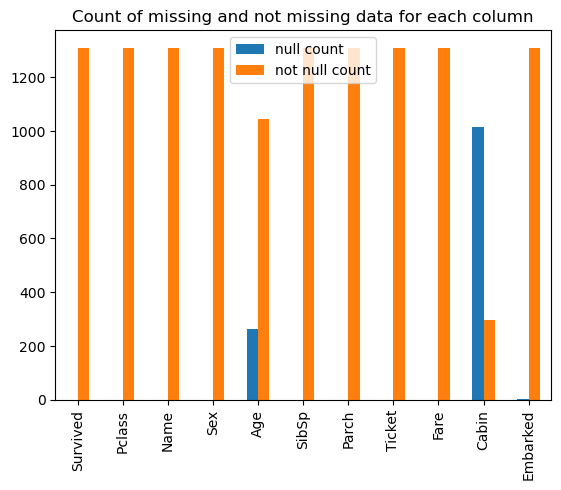

Text(0.5, 0.98, 'Missing vs Not Missing Rate')

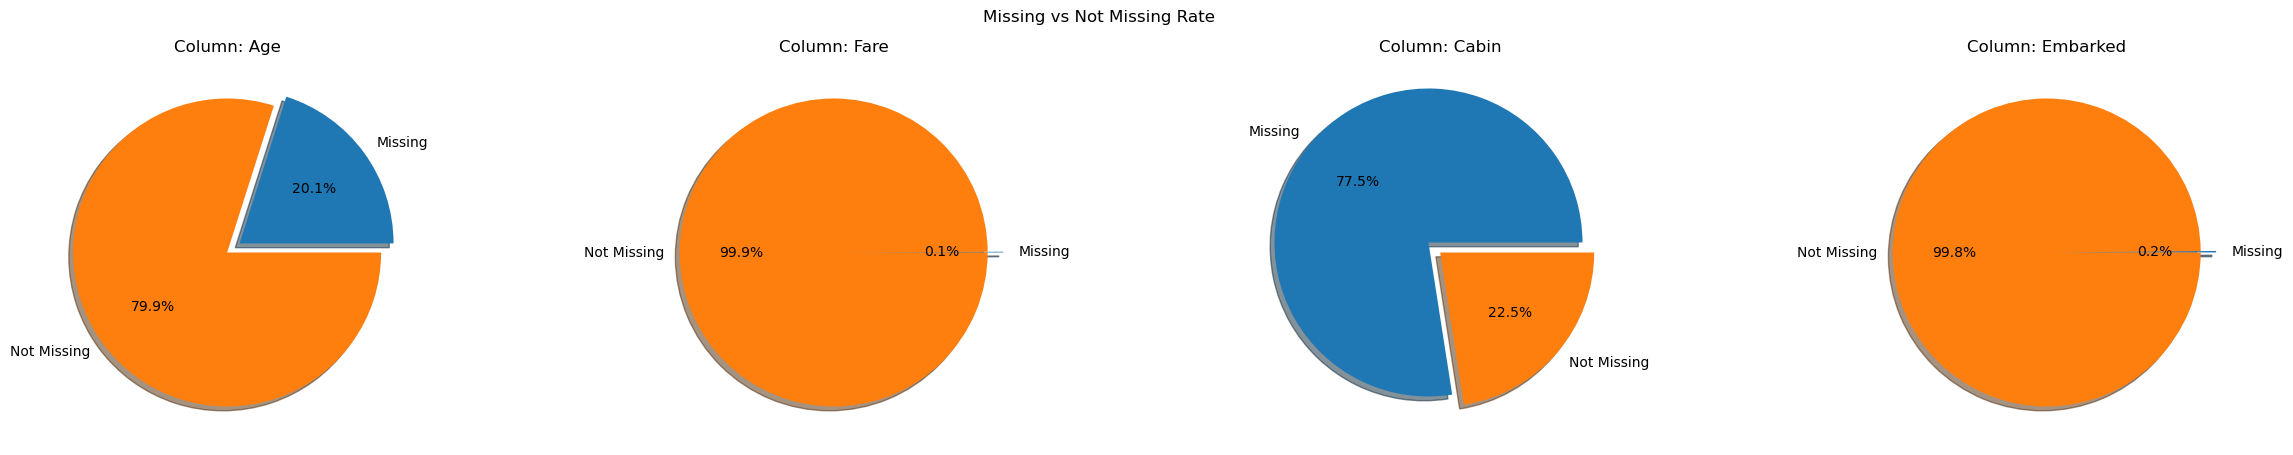

In [78]:
# Bar plot
vis_df.plot(
            kind='bar',
            stacked=False,
            title='Count of missing and not missing data for each column',
                )
plt.legend()
plt.show()

fig, axes = plt.subplots(1, len(null_columns), figsize=(30, 5))
# Pie plots

for i in range(len(null_columns)):
    axes[i].pie(null_columns[i][1:], labels = ['Missing', 'Not Missing'], autopct='%1.1f%%', shadow=True, explode=(0.1, 0) )
    axes[i].set_title(f'Column: {null_columns[i][0]}') 
    

fig.suptitle("Missing vs Not Missing Rate")

I will drop columns `Name`, `Cabin` and `Ticket` because they are obviously not related to the survivel of the passenger.

In [48]:
df = df.drop(['Cabin', 'Ticket', 'Name'], axis=1)

For handling `Fare` null values, we can use the **mean** of `Age` based on `Pclass` and `Sex`.

In [49]:
grouped_series = df.groupby(['Pclass', 'Sex'])['Fare'].mean()
grouped_series

Pclass  Sex   
1       female    109.412385
        male       69.888385
2       female     23.234827
        male       19.904946
3       female     15.324250
        male       12.415462
Name: Fare, dtype: float64

In [57]:
sex, pclass = df.loc[df[df['Fare'].isnull()].index, ['Sex', 'Pclass']].values[0]
df.loc[df[df['Fare'].isnull()].index, 'Fare'] = np.floor(grouped_series[pclass, sex])

Text(0.5, 1.0, 'Fare Mean for Different Combination')

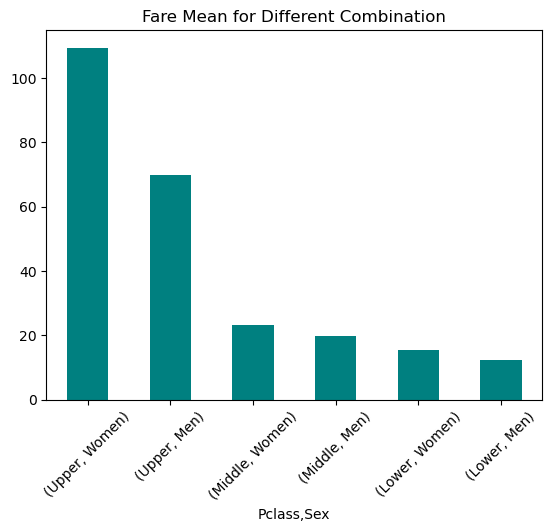

In [79]:
# Note that I ran this cell after converiting int types to categorical, I moved this cell because of content correlation
grouped_series = df.groupby(['Pclass', 'Sex'])['Fare'].mean()
grouped_series.plot.bar(rot=45, color='teal')
plt.title("Fare Mean for Different Combination")


For handling `Embarked` column, we will use the `Pclass` and put the Embarked with the maximum number of entries as the `NaN` values.

In [58]:
df.groupby(['Pclass', 'Embarked'])['SibSp'].count()

Pclass  Embarked
1       C           141
        Q             3
        S           177
2       C            28
        Q             7
        S           242
3       C           101
        Q           113
        S           495
Name: SibSp, dtype: int64

In [59]:
df.loc[df[df['Embarked'].isnull()].index, 'Embarked'] = 'S'

Converting Categorical data to numerical data

In [60]:
df.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [61]:
df['Sex'] = df['Sex'].astype('category')
df['Embarked'] = df['Embarked'].astype('category')

In [62]:
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda c: c.cat.codes)

We use `IterativeImputer` method for filling age missing values.

In [63]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         263
SibSp         0
Parch         0
Fare          0
Embarked      0
dtype: int64

In [64]:
X = df[['Pclass', 'Sex', 'Fare', 'Age']]

imputer = IterativeImputer()
imp_vals = imputer.fit_transform(X)
df[['Pclass', 'Sex', 'Fare', 'Age']] = imp_vals
df['Age'] = df['Age'].apply(lambda age: np.floor(age) if age > 1 else age)

In [65]:
df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

## Converting data types as needed

In [66]:
df['Survived'] = df['Survived'].astype('category')
df['Survived'] = df['Survived'].map({0: 'Died', 1: 'Survived'})

df['Sex'] = df['Sex'].astype('category')
df['Sex'] = df['Sex'].map({0: 'Women', 1: 'Men'})

df['Pclass'] = df['Pclass'].astype('category')
df['Pclass'] = df['Pclass'].map({1: 'Upper', 2:'Middle', 3: 'Lower'})

df['Embarked'] = df['Embarked'].astype('category')
df['Embarked'] = df['Embarked'].map({0: 'Cherbourg', 1:'Queenstown', 2:'Southampton'})

In [67]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,Died,Lower,Men,22.0,1,0,7.2500,Southampton
2,Survived,Upper,Women,38.0,1,0,71.2833,Cherbourg
3,Survived,Lower,Women,26.0,0,0,7.9250,Southampton
4,Survived,Upper,Women,35.0,1,0,53.1000,Southampton
5,Died,Lower,Men,35.0,0,0,8.0500,Southampton


# Statistical Analysis and Visualization

## Passenger's population By Different Groups

In [26]:
gender_series = df.groupby('Sex')['Sex'].count()
gpops = gender_series.values

pclass_series = df.groupby('Pclass')['Pclass'].count()
ppops = pclass_series.values

embarked_series = df.groupby('Embarked')['Embarked'].count()
epops = embarked_series.values



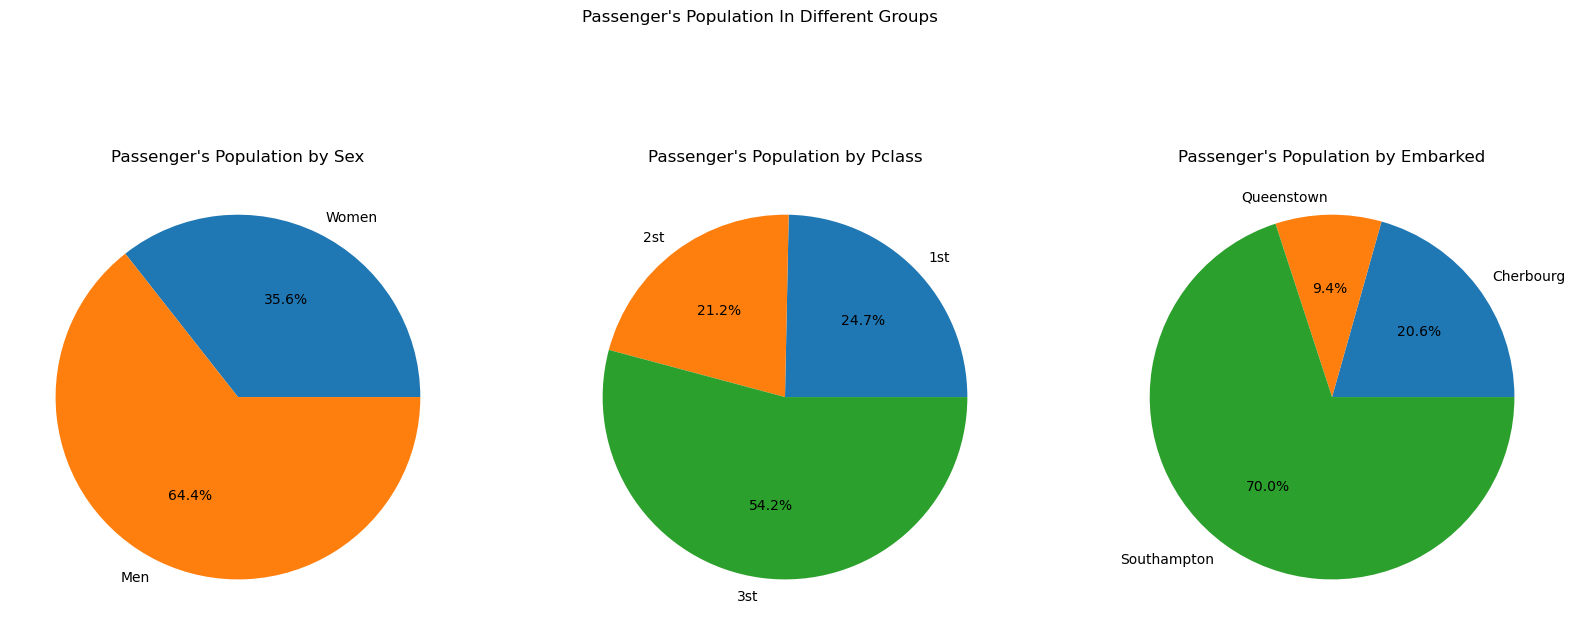

In [27]:
# Plotting
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

axes[0].pie(gpops, labels=['Women', 'Men'], autopct='%1.1f%%')
axes[0].set_title('Passenger\'s Population by Sex')

axes[1].pie(ppops, labels=['1st', '2st', '3st'], autopct='%1.1f%%')
axes[1].set_title('Passenger\'s Population by Pclass')

axes[2].pie(epops, labels=['Cherbourg', 'Queenstown', 'Southampton'], autopct='%1.1f%%')
axes[2].set_title('Passenger\'s Population by Embarked')


fig.suptitle('Passenger\'s Population In Different Groups')
plt.show()

## Survival Rate Between Different Groups

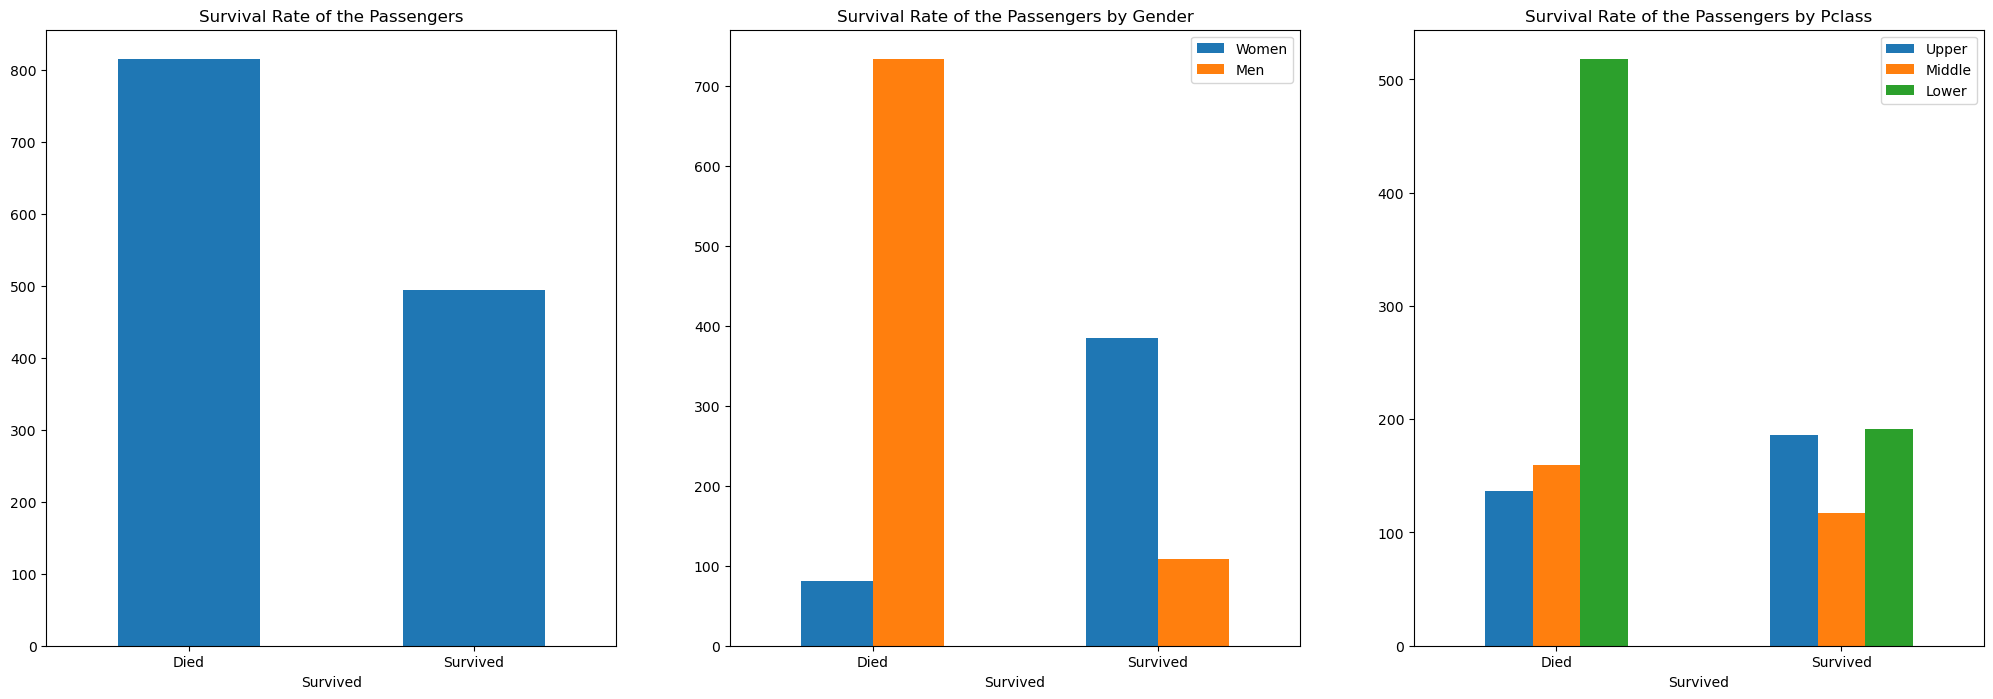

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(25, 8))

df.groupby('Survived')['Survived'].count().plot(
    kind='bar',
    stacked=False,
    ax=axes[0],
    title='Survival Rate of the Passengers',
    rot=False,
)

pd.DataFrame({'Women': df.groupby(['Sex','Survived'])['Survived'].count()['Women'],
                       'Men': df.groupby(['Sex','Survived'])['Survived'].count()['Men']
                       }).plot(
                                kind='bar',
                                ax=axes[1],
                                title='Survival Rate of the Passengers by Gender',
                                rot=False
                           )

pd.DataFrame(
            {'Upper': df.groupby(['Pclass','Survived'])['Survived'].count()['Upper'],
            'Middle': df.groupby(['Pclass','Survived'])['Survived'].count()['Middle'],
            'Lower': df.groupby(['Pclass','Survived'])['Survived'].count()['Lower']}
                    ).plot(
                                kind='bar',
                                ax=axes[2],
                                title='Survival Rate of the Passengers by Pclass',
                                rot=False
                           )

plt.show()

## Passenger's Age distribution
The `Age` distribution is drawn and a kernel density estimator (aka. `KDE`) is applied for more perspective.

The black line is the mean of `Age`.

### Distribution Plots

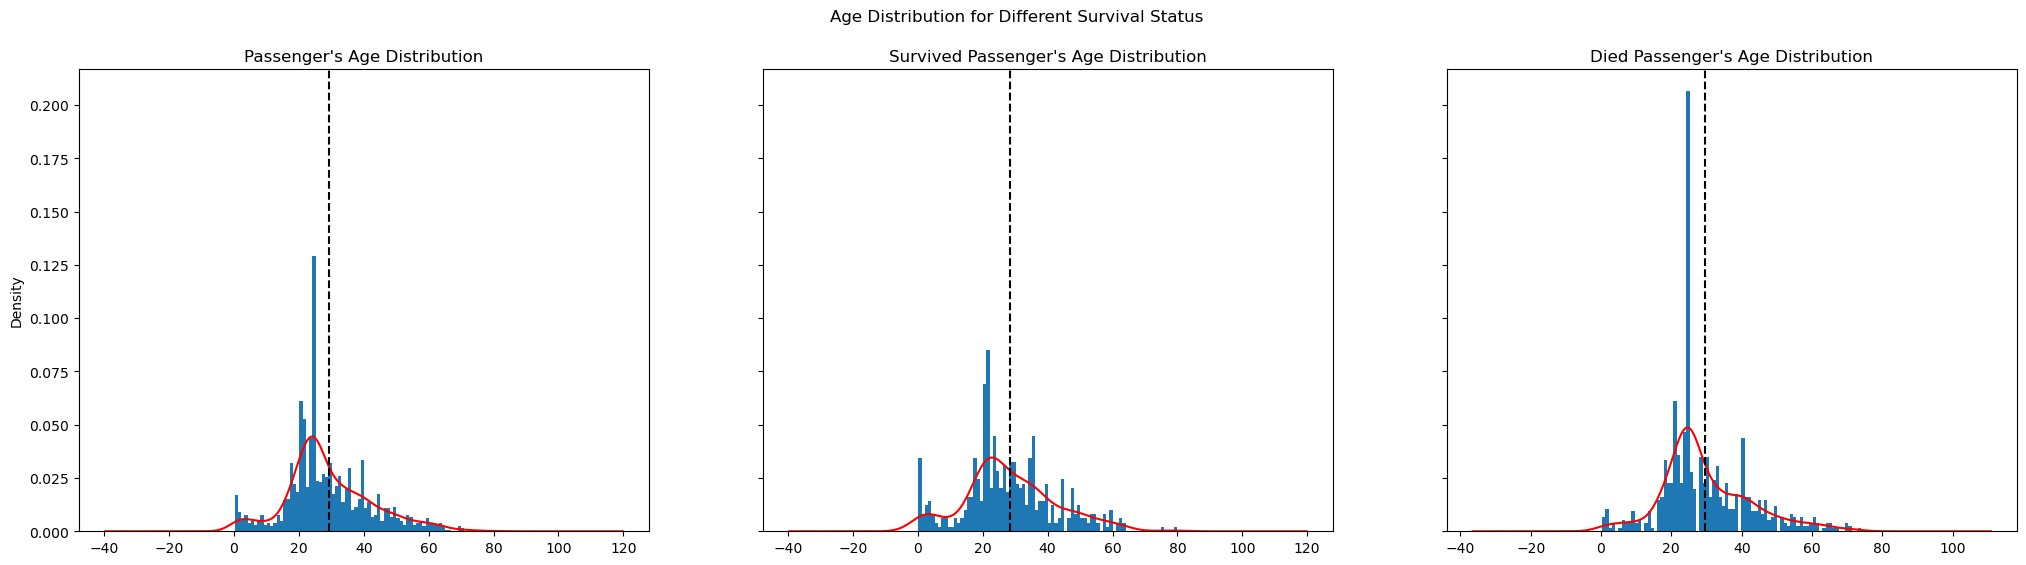

In [70]:
fig, axes = plt.subplots(1, 3, figsize=(25, 6), sharey=True)


# Hist 1
min_age = df['Age'].min()
max_age = df['Age'].max()

df['Age'].plot(
    kind='hist',
    bins=80,
    density=True,
    ax=axes[0]
)

df['Age'].plot(
    kind='kde',
    colormap='autumn',
    ax=axes[0]
)
axes[0].axvline(df['Age'].mean(), ls='--', color='black')

axes[0].set_title('Passenger\'s Age Distribution')

# Hist 2
df[df['Survived'] == 'Survived']['Age'].plot(
    kind='hist',
    bins=80,
    density=True,
    ax=axes[1]
)

df[df['Survived'] == 'Survived']['Age'].plot(
    kind='kde',
    colormap='autumn',
    ax=axes[1]
)
axes[1].axvline(df[df['Survived'] == 'Survived']['Age'].mean(), ls='--', color='black')

axes[1].set_title('Survived Passenger\'s Age Distribution')

# Hist 3
df[df['Survived'] == 'Died']['Age'].plot(
    kind='hist',
    bins=80,
    density=True,
    ax=axes[2]
)

df[df['Survived'] == 'Died']['Age'].plot(
    kind='kde',
    colormap='autumn',
    ax=axes[2]
)
axes[2].axvline(df[df['Survived'] == 'Died']['Age'].mean(), ls='--', color='black')

axes[2].set_title('Died Passenger\'s Age Distribution')


plt.suptitle("Age Distribution for Different Survival Status")
plt.show()

### Box Plots

#### Box Plot of `Age`

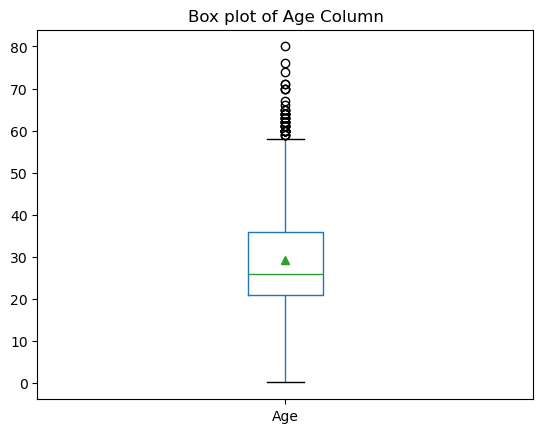

In [96]:
df.boxplot(
    column='Age',
    showmeans=True,
    grid=False
)

plt.title('Box plot of Age Column')
plt.show()

#### Box Plot for `Age` by Survival Status

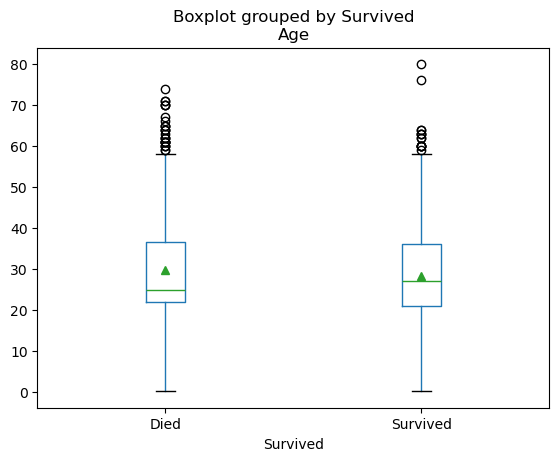

In [100]:
df.boxplot(
    by='Survived',
    column='Age',
    grid=False,
    showmeans=True
)

plt.show()

#### Box Plot for `Age` by Class

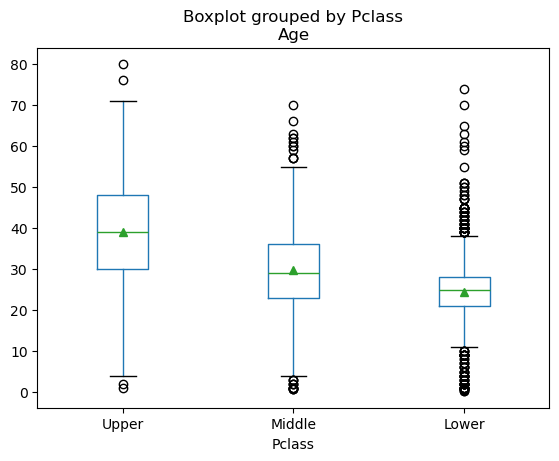

In [102]:
df.boxplot(
    by='Pclass',
    column='Age',
    grid=False,
    showmeans=True
)

plt.show()

## Correlation Analysis Between Family population and Survival

### Making a New Data Frame
Adding column `Family_pop` which is the population of the family of each passenger.

In [126]:
new_df = df.copy(deep=True)
new_df.insert(2, "Family_pop", df['SibSp'] + df['Parch'], True)
new_df.drop(columns=['Parch', 'SibSp'], axis=1, inplace=True)

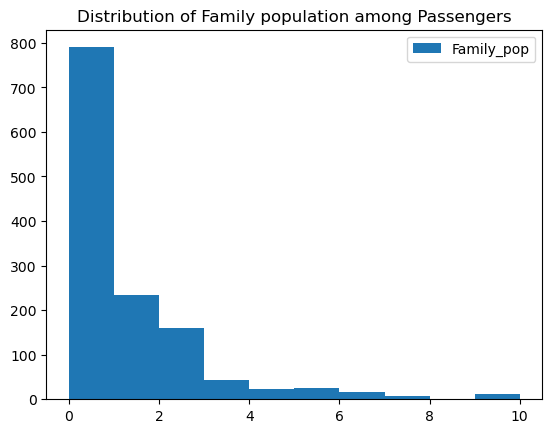

In [170]:
new_df.hist(
    column='Family_pop',
    grid=False,
    legend=True
)

plt.title('Distribution of Family population among Passengers')
plt.show()

### Correlation Matrix

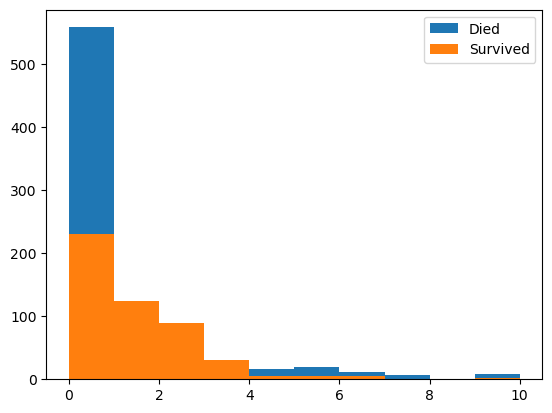

In [163]:
new_df.groupby('Survived')['Family_pop'].hist(
    grid=False,
    legend=True,
    bins=10
)


plt.show()
